In [58]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import glob
import random
import torch
from torchvision import transforms

In [59]:
def sample_tile_images(N_cancer, N_noncancer, path):
    cancer_imgs = glob.glob(os.path.join(path, '*_cancer.png')) # select all file paths of images containing cancer
    noncancer_imgs = glob.glob(os.path.join(path, '*_noncancer.png')) # same for images not containing any cancer
    tiles = random.sample(cancer_imgs, N_cancer) + random.sample(noncancer_imgs, N_noncancer) # sample N_cancer and N_noncancer file paths from the two lists above
    labels = np.concatenate((np.ones(N_cancer), np.zeros(N_noncancer))) # label as 1 for cancer and 0 for non-cancer
    indices = list(range(N_cancer + N_noncancer)) 
    random.shuffle(indices) # random list of indices to shuffle the list containing cancer and non-cancer file paths
    return [tiles[i] for i in indices], labels[indices]

non-cancer


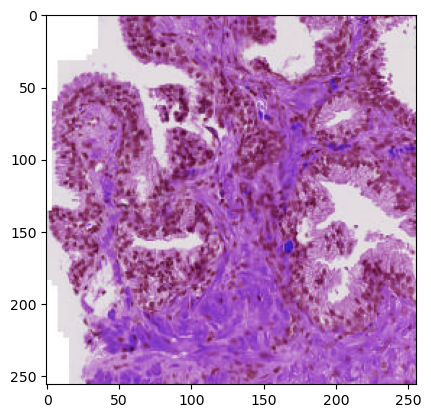

In [60]:
path = "data/tiled_images/output/" # path to the folder containing the imgs

cancer_imgs = glob.glob(os.path.join(path, '*_cancer.png')) # select all file paths of images containing cancer
noncancer_imgs = glob.glob(os.path.join(path, '*_noncancer.png')) # same for images not containing any cancer
# len(cancer_imgs)
# len(noncancer_imgs)

N_cancer = 1000 # number of imgs with cancer
N_noncancer = 2000 # number of imgs without cancer

# Display some random images to observe the features of cancer vs non-cancer cells
tiles, labels = sample_tile_images(N_cancer, N_noncancer, path) # get list of train images
label_dict = {1: 'cancer', 0: 'non-cancer'} # dictionary of labels
# j = random.randint(0, len(labels)) # pick a random image
j = 0 # pick a random image
im_frame = Image.open(tiles[j])
np_frame = np.array(im_frame)
plt.imshow(np_frame)
print(label_dict[labels[j]])

In [61]:
def train_model(net, dataloader, criterion, optimizer, epochs=5):
    i = 0
    run_loss = 0
    # print start
    print('Start of training')
    for epoch in range(epochs):
        print('Epoch:', epoch)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        # print statistics
        print('Loss:', run_loss, '\n')
        run_loss = 0.0
        
    return net

In [62]:
# Split and prepare data for training
train_fraction = 0.7 # fraction of train samples
pxsize = 256 # size of the images to be used by the network, can be center-cropped below 256
random.seed(0)
tiles, labels = sample_tile_images(N_cancer, N_noncancer, path) # get list of train images

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(pxsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data = preprocess(Image.open(tiles[0]).convert('RGB')).reshape(1,3,pxsize,pxsize) # convert to RGB to drop alpha (transparency) channel of png 

for tile in tiles[1:]:
    data = torch.cat((preprocess(Image.open(tile).convert('RGB')).reshape(1,3,pxsize,pxsize), data), axis=0)

X_train, X_validation = torch.split(data, int(train_fraction*len(data)))
y_train, y_validation = torch.split(torch.Tensor(labels).type(torch.LongTensor), int(train_fraction*len(labels)))

In [63]:
# Define hyperparamerts of the network and train it
batch_size = 32
train_dataset = TensorDataset(X_train, y_train) 
dataloader = DataLoader(train_dataset, batch_size = batch_size)
res50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
res50.fc = nn.Sequential(
               nn.Linear(2048, 512),
               nn.ReLU(inplace=True),
               nn.Linear(512, 64),
               nn.ReLU(inplace=True),
               nn.Linear(64, 2),
               nn.Softmax())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res50.fc.parameters())

net = train_model(res50, dataloader, criterion, optimizer, epochs=5)

Start of training
Epoch: 0


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix

pred_labels = torch.argmax(net(X_validation), axis=1)
print("Predicted labels")
print(pred_labels)
print("True labels")
print(y_validation)

C = confusion_matrix(pred_labels, y_validation)
print("Confusion Matrix")
print(C)
print("Accuracy: ", (sum(pred_labels==y_validation)/len(pred_labels)).item())